<a href="https://colab.research.google.com/github/newmantic/T-SNE/blob/main/T_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
from scipy.special import softmax

In [2]:
class TSNE:
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=1000):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter

    def _h_beta(self, distances, beta):
        P = np.exp(-distances * beta)
        sum_P = np.sum(P)
        H = np.log(sum_P) + beta * np.sum(distances * P) / sum_P
        P = P / sum_P
        return H, P

    def _binary_search(self, distances, target_perplexity, tol=1e-5, max_iter=50):
        beta_min = -np.inf
        beta_max = np.inf
        beta = 1.0
        H, P = self._h_beta(distances, beta)
        H_diff = H - np.log(target_perplexity)

        iter_count = 0
        while np.abs(H_diff) > tol and iter_count < max_iter:
            if H_diff > 0:
                beta_min = beta
                if beta_max == np.inf:
                    beta *= 2
                else:
                    beta = (beta + beta_max) / 2
            else:
                beta_max = beta
                if beta_min == -np.inf:
                    beta /= 2
                else:
                    beta = (beta + beta_min) / 2

            H, P = self._h_beta(distances, beta)
            H_diff = H - np.log(target_perplexity)
            iter_count += 1

        return P

    def _compute_joint_probabilities(self, X):
        distances = pairwise_distances(X, metric='euclidean')**2
        n_samples = X.shape[0]
        P = np.zeros((n_samples, n_samples))

        for i in range(n_samples):
            P[i, :] = self._binary_search(distances[i, :], self.perplexity)

        P = (P + P.T) / (2 * n_samples)
        return P

    def _compute_low_dim_affinities(self, Y):
        distances = pairwise_distances(Y, metric='euclidean')**2
        Q = 1 / (1 + distances)
        np.fill_diagonal(Q, 0)
        Q /= np.sum(Q)
        return Q

    def _kl_divergence(self, P, Q):
        return np.sum(P * np.log((P + 1e-10) / (Q + 1e-10)))

    def fit_transform(self, X):
        n_samples = X.shape[0]

        # Step 1: Compute joint probabilities in high-dimensional space
        P = self._compute_joint_probabilities(X)

        # Step 2: Initialize low-dimensional map with random values
        Y = np.random.randn(n_samples, self.n_components)

        # Step 3: Gradient descent to minimize KL divergence
        for iter in range(self.n_iter):
            Q = self._compute_low_dim_affinities(Y)
            grad = np.zeros_like(Y)

            PQ_diff = P - Q
            for i in range(n_samples):
                grad[i, :] = 4 * np.sum((PQ_diff[:, i] * Q[:, i]).reshape(-1, 1) * (Y[i, :] - Y), axis=0)

            Y += self.learning_rate * grad

            if iter % 100 == 0:
                loss = self._kl_divergence(P, Q)
                print(f"Iteration {iter}: KL Divergence = {loss}")

        return Y

Iteration 0: KL Divergence = 6.771624418122998
Iteration 100: KL Divergence = 6.771625100335438
Iteration 200: KL Divergence = 6.771625782548429
Iteration 300: KL Divergence = 6.771626464761954
Iteration 400: KL Divergence = 6.771627146976011
Iteration 500: KL Divergence = 6.771627829190611
Iteration 600: KL Divergence = 6.771628511405738
Iteration 700: KL Divergence = 6.771629193621405
Iteration 800: KL Divergence = 6.771629875837613
Iteration 900: KL Divergence = 6.771630558054338


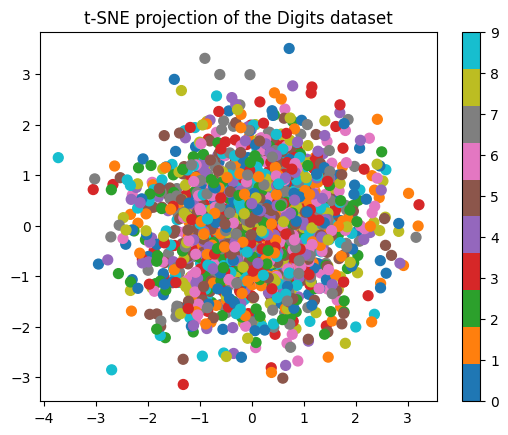

In [3]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load dataset
data = load_digits()
X = data.data
y = data.target

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=1000)

# Fit and transform data
embedding = tsne.fit_transform(X)

# Plot the results
plt.scatter(embedding[:, 0], embedding[:, 1], c=y, cmap='tab10', s=50)
plt.colorbar()
plt.title('t-SNE projection of the Digits dataset')
plt.show()